# setup

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import re
import pickle
import random
from typing import Sequence, Tuple
from tempfile import mkdtemp
from datetime import datetime

import optuna
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.metrics import auc, roc_auc_score, accuracy_score, f1_score, precision_score, recall_score

from catboost import CatBoostClassifier, Pool

pd.set_option('display.max_rows', 100)

In [64]:
from src.io import csv_loader_factory, PickleLoader
from src.preprocessing import TextCleaner
from src.embeddings import W2VEmbedder
from src.eval.metrics import compute_metrics

from src.eval.metrics import compute_metrics, plot_preds

# optuna res

In [40]:
name = 'test_study_20220110_0025.pkl'
path = os.path.join('./opt_studies/', name)

with open(path, 'rb') as p:
    study = pickle.load(p)

study_df = study.trials_dataframe()
study_df['is_best'] = 0
study_df.loc[[t.number for t in study.best_trials], 'is_best'] = 1

run = len(study_df)
completed = len(study_df[study_df['state']=='COMPLETE'])

print(f'run: {run}, compleated: {completed} ({round(completed/run, 3)})')
study_df[study_df['is_best']==1].sort_values('values_0', ascending=False)

run: 236, compleated: 229 (0.97)


,number,values_0,values_1,datetime_start,datetime_complete,duration,params_grow_policy,params_latinize,params_learning_rate,params_max_depth,params_min_data_in_leaf,params_ngram_range_hi,params_reg_lambda,params_selector_p_value_limit,params_stopwords_tresh,params_to_lower,system_attrs_nsga2:generation,system_attrs_nsga2:parents,state,is_best
27,27,0.796082,0.045016,2022-01-10 00:36:00.478575,2022-01-10 00:58:11.026299,0 days 00:22:10.547724,SymmetricTree,True,0.051,9,21,2,7,0.00,0.161,True,0,NaN,COMPLETE,1
112,112,0.794113,0.048000,2022-01-10 01:59:42.546251,2022-01-10 03:31:33.291507,0 days 01:31:50.745256,Depthwise,False,0.016,16,1,1,5,0.10,0.176,True,1,"[6, 9]",COMPLETE,1
57,57,0.787016,0.055749,2022-01-10 00:57:13.762210,2022-01-10 04:10:44.714691,0 days 03:13:30.952481,SymmetricTree,False,0.086,13,11,2,5,0.05,0.021,False,1,"[38, 34]",COMPLETE,1
185,185,0.782656,0.063241,2022-01-10 03:41:57.263699,2022-01-10 04:27:24.971800,0 days 00:45:27.708101,Depthwise,False,0.056,16,1,1,5,0.10,0.176,True,3,"[112, 112]",COMPLETE,1
64,64,0.781841,0.064257,2022-01-10 01:00:49.309418,2022-01-10 03:18:41.000743,0 days 02:17:51.691325,SymmetricTree,False,0.051,12,1,1,7,0.00,0.131,True,1,"[41, 54]",COMPLETE,1
6,6,0.774336,0.075949,2022-01-10 00:25:58.186470,2022-01-10 00:42:20.058178,0 days 00:16:21.871708,Depthwise,False,0.076,16,1,1,5,0.00,0.021,True,0,NaN,COMPLETE,1
128,128,0.756446,0.076596,2022-01-10 02:13:47.968011,2022-01-10 02:19:14.471185,0 days 00:05:26.503174,Lossguide,False,0.026,11,81,1,9,0.35,0.086,True,2,"[16, 0]",COMPLETE,1
216,216,0.749341,0.085837,2022-01-10 04:40:46.922314,2022-01-10 04:44:08.559890,0 days 00:03:21.637576,Depthwise,False,0.051,11,71,1,9,0.35,0.181,False,3,"[142, 108]",COMPLETE,1
209,209,0.746751,0.094421,2022-01-10 04:29:21.240030,2022-01-10 04:32:05.995005,0 days 00:02:44.754975,Lossguide,False,0.041,5,101,1,5,0.35,0.116,False,3,"[120, 50]",COMPLETE,1
227,227,0.746751,0.094421,2022-01-10 04:56:19.480096,2022-01-10 04:58:59.934021,0 days 00:02:40.453925,Lossguide,False,0.041,5,101,1,5,0.35,0.116,False,4,"[209, 209]",COMPLETE,1


In [41]:
study_df[study_df['is_best']==1].sort_values('values_0', ascending=False).iloc[-1, :]

number                                                  146
values_0                                           0.626435
values_1                                                0.2
datetime_start                   2022-01-10 02:57:12.269890
datetime_complete                2022-01-10 02:59:34.109957
duration                             0 days 00:02:21.840067
params_grow_policy                                Lossguide
params_latinize                                       False
params_learning_rate                                  0.026
params_max_depth                                         11
params_min_data_in_leaf                                  71
params_ngram_range_hi                                     3
params_reg_lambda                                         5
params_selector_p_value_limit                           0.7
params_stopwords_tresh                                0.036
params_to_lower                                        True
system_attrs_nsga2:generation           

<AxesSubplot:xlabel='auc', ylabel='f1'>

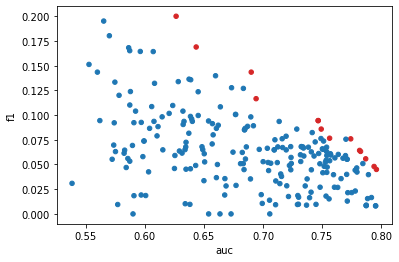

In [35]:
dfp = study_df[study_df['state']=='COMPLETE'][['values_0', 'values_1', 'is_best']].rename({'values_0': 'auc', 'values_1': 'f1'}, axis=1)

color_map ={
    1: 'tab:red',
    0: 'tab:blue'
}
colors = dfp['is_best'].replace(color_map)
dfp.plot.scatter(x='auc', y='f1', c=colors)


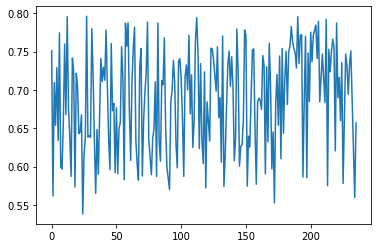

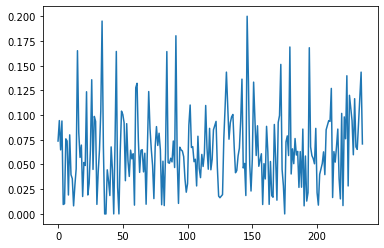

In [37]:
dfp = study_df[study_df['state']=='COMPLETE'][['number', 'values_0', 'values_1']].rename({'values_0': 'auc', 'values_1': 'f1'}, axis=1)

dfp['auc'].plot()
plt.show()
dfp['f1'].plot()
plt.show()

In [38]:
imp_auc = optuna.importance.get_param_importances(study, target=lambda t: t.values[0])
imp_f1 = optuna.importance.get_param_importances(study, target=lambda t: t.values[1])

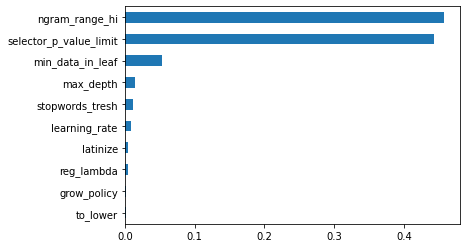

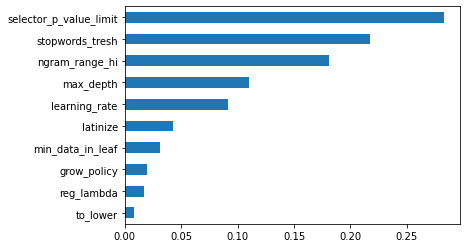

In [39]:
pd.Series(imp_auc).sort_values().plot.barh()
plt.show()

pd.Series(imp_f1).sort_values().plot.barh()
plt.show()

**Insights**:  

Text cleaner
* `params_latinize` minor impact -> can be defaulted to **False**
* `params_to_lower` lowers both **auc** and **f1** -> default to **False**

W2V Encoder
* positive corr of `epochs` with **f1** -> increase max number of `epoch` ~20
* !**auc** and **f1** has almost perfect negative corellation with respect to number of `epoch`
* increase `params_alpha` significant increasing trend of **f1** -> max should be increased to 0.2
* `params_max_final_vocab` should be between 10-15k
* `params_min_count`:  
    * **auc** is maximized in 100-125 range
    * **f1** max around 50-60, negative corr
* `params_ns_exponent` best metric values between -0.2 and 0.2, above 0.2 both metrics decrease
* `params_sg` minor impact on average metrics -> fix at 0
* `params_vector_size`  
Best **auc** values match lowest **f1** values. Similarly in the oher side
    * **auc** best values between 400 and 750
    * **f1** best values between 300 and 600

Learner
* `params_learning_rate` slight increasing trend of **f1** -> max should be increased to 0.2
* ?`params_grow_policy` other than *Lossguide* failed
* `params_max_depth`: negative corr with **auc** and positive with **f1**
Best **auc** at 3, best **f1** at 13
* `params_min_data_in_leaf` both metrics has positive corr -> should be increased to ~200
* `params_num_leaves` significant impact, similar to max_depth
Best **auc** at 5, best **f1** at 35
* `params_reg_lambda` minor impact, should be between 3 and 7, can be fixed to 5/6
Best **auc** at 3, best **f1** at 7

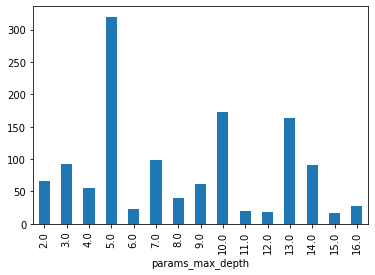

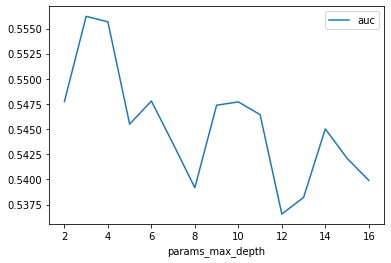

<AxesSubplot:xlabel='params_max_depth'>

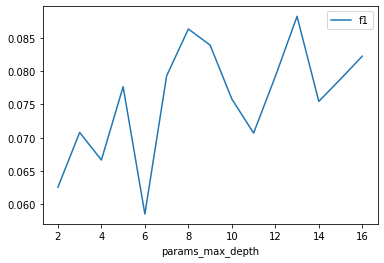

In [112]:
dfg = study_df.groupby('params_max_depth').agg(
    size=('params_grow_policy', 'size'),
    auc=('values_0', 'median'),
    f1=('values_1' ,'median')
)

dfg['size'].plot(kind='bar')
plt.show()
dfg[['auc']].plot()
plt.show()
dfg[['f1']].plot()

# train best model

## def

In [60]:
import pickle
from datetime import datetime
from collections import Counter

import pandas as pd
import numpy as np
import spacy
import optuna
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.feature_selection import chi2
from sklearn.feature_extraction.text import TfidfVectorizer

from src.preproc import tokenize
from src.io import csv_loader_factory
from src.preprocessing import TextCleaner
from src.embeddings import W2VEmbedder

def make_stopwords(texts: pd.Series, freq_tresh: float = 0.02):
    words = list(map(lambda str: str.split(), texts))
    words = [item for sublist in words for item in sublist]

    words_count = Counter(words)

    return set([k for k, v in words_count.items() if v > len(texts) * freq_tresh])

def lemmatize_pipe(doc, stopwords):
    lemma_list = [str(tok.lemma_).lower() for tok in doc
                  if tok.text.lower() not in stopwords
                 ] 
    return ' '.join(lemma_list)

def preprocess_pipe(texts, stopwords):
    if isinstance(texts, str): texts = [texts]
    preproc_pipe = []
    for doc in nlp.pipe(texts, batch_size=20):
        preproc_pipe.append(lemmatize_pipe(doc, stopwords))
    return pd.Series(preproc_pipe, index=texts.index)

def train_params(params):
    # clean
    cleaner_params = {
        'latinize': params['latinize'],
        'to_lower': params['to_lower'],
    }
    cleaner = TextCleaner(**cleaner_params)
    train_clean = cleaner.fit_transform(train_raw)
    test_clean = cleaner.transform(test_raw)

    # stop words
    freq_tresh = params["stopwords_tresh"]
    stopwords = make_stopwords(train_clean, freq_tresh)

    # lemmatize
    train_prepro = preprocess_pipe(train_clean, stopwords)
    test_prepro = preprocess_pipe(test_clean, stopwords)

    # vectorize
    ngram_range_hi =  params['ngram_range_hi']
    vec_params = {
        'ngram_range': (1, ngram_range_hi)
    }
    vectorizer = TfidfVectorizer(**vec_params)
    train_vec = vectorizer.fit_transform(train_prepro)

    # select words with with chi2
    _, p = chi2(train_vec, train_label)
    df_selection = pd.DataFrame({'feature': vectorizer.get_feature_names_out(), 'score': 1-p})
    p_value_limit =  params['selector_p_value_limit'],
    features_selected = df_selection[df_selection['score'] > p_value_limit]['feature']

    # vectorize on selected
    vec_params = {
        'ngram_range': (1, ngram_range_hi),
        'vocabulary': features_selected
    }
    vectorizer = TfidfVectorizer(**vec_params)
    vectorizer.fit(train_prepro)    
    train_vec = vectorizer.transform(train_prepro)
    test_vec = vectorizer.transform(test_prepro)

    
    # fit model
    cb_params = {
        'eval_metric': 'AUC',
        'early_stopping_rounds': 50,
        'verbose': 50,
        'grow_policy': params['grow_policy'],
        'min_data_in_leaf': params['min_data_in_leaf'],
        'learning_rate': params['learning_rate'],
        'reg_lambda': params['reg_lambda'],
        'max_depth': params['max_depth'],
    }
    if cb_params == 'Lossguide':
        cb_params_lg = {
            'num_leaves': params['num_leaves']
        }
        cb_params.update(cb_params_lg)

    cb = CatBoostClassifier(**cb_params)
    cb.fit(X=train_vec, y=train_label, eval_set=(test_vec, test_label))
    
    proba_train = cb.predict_proba(train_vec)[:, 1]
    proba_test = cb.predict_proba(test_vec)[:, 1]
    
    return proba_train, proba_test

In [43]:
print('loading model')
nlp = spacy.load('pl_core_news_md', disable=['parser', 'tagger', 'ner', 'attribute_ruler'])

print('loading data')
loader = csv_loader_factory('poleval')
data = loader.load()

train_raw = data.loc[data['dataset']=='train', 'text_raw']
train_label = data.loc[data['dataset']=='train', 'tag']
test_raw = data.loc[data['dataset']=='test', 'text_raw']
test_label = data.loc[data['dataset']=='test', 'tag']

loading model


INFO:2022-01-10 05:33:13:io:loading from csv: ./data/poleval19.csv
INFO:2022-01-10 05:33:14:io:loaded 11041 rows


loading data


In [ ]:
def get_optuna_params(trial_id: int):
    trial_data = study_df[study_df['is_best']==1].sort_values('values_0', ascending=False).loc[trial_id, :]
    return {re.sub('params_', '', k): v for k, v in trial_data.filter(regex='param').to_dict().items()}

## best auc

In [70]:
trial_id = study_df[study_df['is_best']==1].sort_values('values_0', ascending=False).iloc[0, :]['number']

params = get_optuna_params(trial_id)
params

{'grow_policy': 'SymmetricTree',
 'latinize': True,
 'learning_rate': 0.051000000000000004,
 'max_depth': 9,
 'min_data_in_leaf': 21,
 'ngram_range_hi': 2,
 'reg_lambda': 7,
 'selector_p_value_limit': 0.0,
 'stopwords_tresh': 0.161,
 'to_lower': True}

In [76]:
proba_train_auc, proba_test_auc = train_params(params)

,train,test
AUC,0.905483,0.796082
Accuracy,0.830694,0.703000
F1,0.001175,0.045016
Precision,0.001175,0.039548
Recall,0.001175,0.052239
Mean,0.083607,0.085360


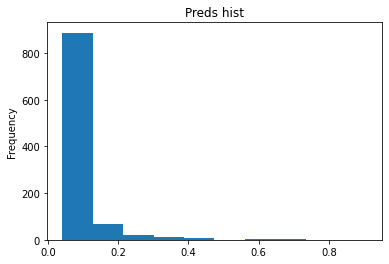

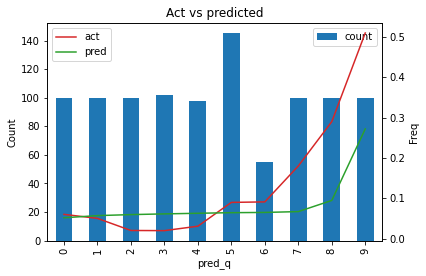

,count,act,pred
pred_q,,,
0,100,0.060000,0.051511
1,100,0.050000,0.056872
2,100,0.020000,0.059362
3,102,0.019608,0.061153
4,98,0.030612,0.062683
5,145,0.089655,0.064169
6,55,0.090909,0.064755
7,100,0.180000,0.066834
8,100,0.290000,0.094542


In [74]:
display(compute_metrics((train_label, proba_train_auc), (test_label, proba_test_auc)))
plot_preds(test_label, proba_test_auc)

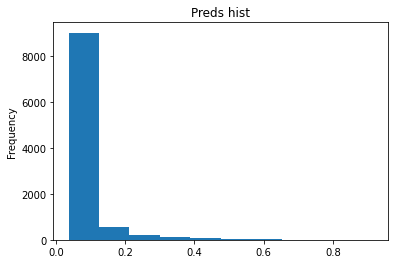

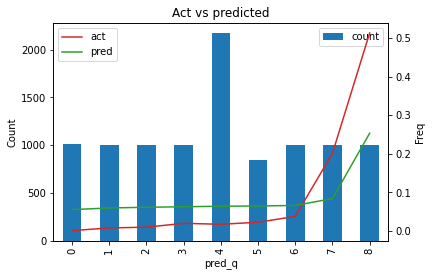

In [88]:
df = plot_preds(train_label, proba_train_auc)

<AxesSubplot:xlabel='pred_q'>

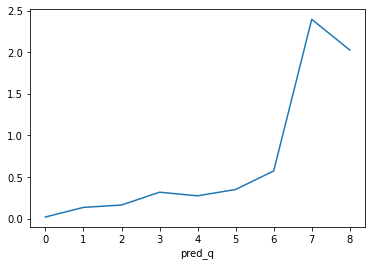

In [90]:
df['diff'] = df['act']/df['pred']
df['diff'].plot()

## best f1

In [72]:
trial_id = study_df[study_df['is_best']==1].sort_values('values_0', ascending=False).iloc[-1, :]['number']

params = get_optuna_params(trial_id)
params

{'grow_policy': 'Lossguide',
 'latinize': False,
 'learning_rate': 0.026000000000000002,
 'max_depth': 11,
 'min_data_in_leaf': 71,
 'ngram_range_hi': 3,
 'reg_lambda': 5,
 'selector_p_value_limit': 0.7000000000000001,
 'stopwords_tresh': 0.036000000000000004,
 'to_lower': True}

In [78]:
proba_train_f1, proba_test_f1 = train_params(params)

,train,test
AUC,0.922485,0.626435
Accuracy,0.861568,0.840000
F1,0.001437,0.200000
Precision,0.001848,0.303030
Recall,0.001175,0.149254
Mean,0.088536,0.076460


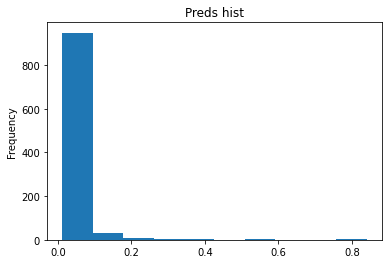

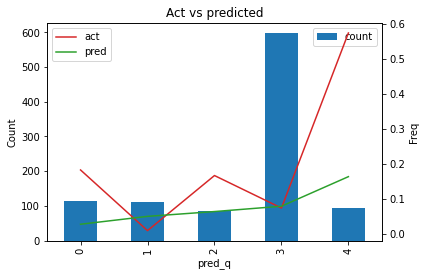

,count,act,pred
pred_q,,,
0,115,0.182609,0.027399
1,110,0.009091,0.049913
2,84,0.166667,0.063678
3,597,0.073702,0.078900
4,94,0.574468,0.163475


In [75]:
display(compute_metrics((train_label, proba_train_f1), (test_label, proba_test_f1)))
plot_preds(test_label, proba_test_f1)

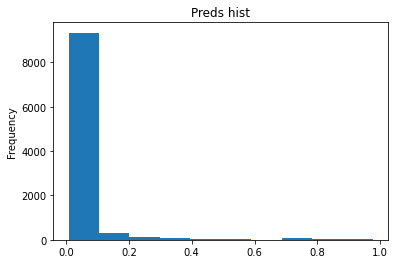

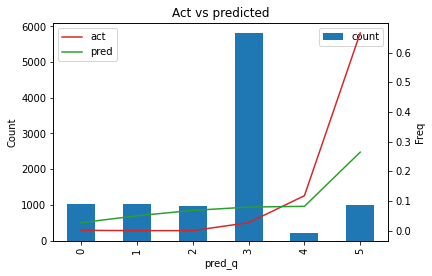

In [108]:
df = plot_preds(train_label, proba_train_f1)

<AxesSubplot:xlabel='pred_q'>

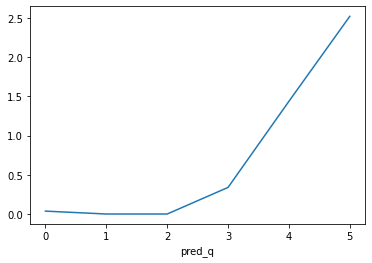

In [109]:
df['diff'] = df['act']/df['pred']
df['diff'].plot()

## confusion_matrix

In [99]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [95]:
tresh_auc = np.quantile(proba_train_auc, np.mean(train_label))
tresh_f1 = np.quantile(proba_train_f1, np.mean(train_label))

pred_train_auc = (proba_train_auc<tresh_auc).astype(int)
pred_test_auc = (proba_test_auc<tresh_auc).astype(int)

pred_train_f1 = (proba_train_f1<tresh_f1).astype(int)
pred_test_f1 = (proba_test_f1<tresh_f1).astype(int)

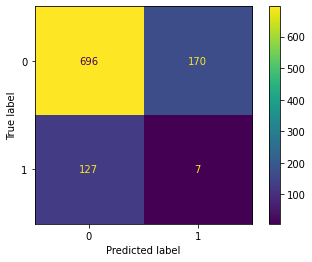

In [102]:
ConfusionMatrixDisplay(confusion_matrix(test_label, pred_test_auc)).plot()

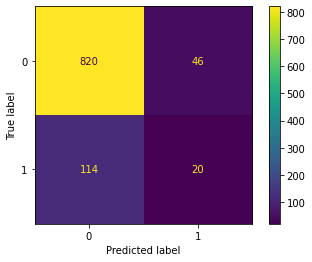

In [103]:
ConfusionMatrixDisplay(confusion_matrix(test_label, pred_test_f1)).plot()

## mean

In [83]:
proba_train_mean = pd.Series([np.mean([a, b]) for a,b in zip(proba_train_auc, proba_train_f1)])
proba_test_mean = pd.Series([np.mean([a, b]) for a,b in zip(proba_test_auc, proba_test_f1)])

,train,test
AUC,0.945690,0.758075
Accuracy,0.830694,0.774000
F1,0.001175,0.050420
Precision,0.001175,0.057692
Recall,0.001175,0.044776
Mean,0.086071,0.080910


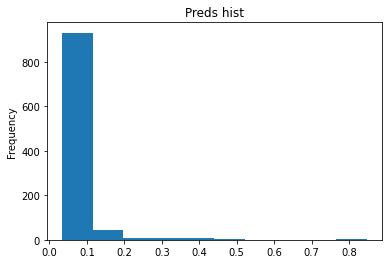

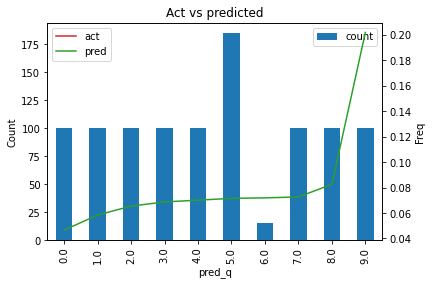

,count,act,pred
pred_q,,,
0.0,100,NaN,0.046542
1.0,100,NaN,0.058393
2.0,100,NaN,0.065393
3.0,100,NaN,0.068704
4.0,100,NaN,0.070078
5.0,185,NaN,0.071510
6.0,15,NaN,0.071880
7.0,100,NaN,0.072609
8.0,100,NaN,0.082538


In [84]:
display(compute_metrics((train_label, proba_train_mean), (test_label, proba_test_mean)))
plot_preds(test_label, proba_test_mean)

# callibrate

In [116]:
from sklearn.linear_model import LogisticRegression

In [117]:
cal = LogisticRegression()

In [211]:
lo = np.log(proba_train_f1/(1-proba_train_f1))

In [199]:
cal.fit(lo, train_label)
pred_cal = cal.predict_proba(lo)[:, 1]

In [205]:
cal.coef_[0][0]

3.4124826774473447

In [207]:
cal.intercept_[0]

5.442670235608918

In [220]:
def logit(x, a=3.4124826774473447, b=5.44):
    return 1/(1+np.exp(-a*x-b))

In [222]:
pc = pd.Series(map(logit, lo))
np.mean(pc)

0.08463481814844796

<AxesSubplot:xlabel='pred_q'>

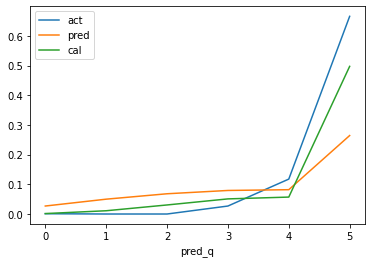

In [228]:
df = pd.DataFrame({'act': train_label, 'pred': proba_train_f1, 'cal': pc})
df['pred_q'] = pd.qcut(df['pred'], q=[x/10 for x in range(11)], labels=False, duplicates='drop')

df.groupby('pred_q').agg(
    act=('act', 'mean'),
    pred=('pred', 'mean'),
    cal=('cal', 'mean')
).plot()

In [229]:

tresh = np.quantile(pc, np.mean(train_label))
pred_cal = (pc<tresh).astype(int)

In [234]:
df['pred']

0        0.044922
1        0.014475
2        0.060322
3        0.034061
4        0.034061
           ...   
10036    0.019065
10037    0.034061
10038    0.079372
10039    0.068313
10040    0.079372
Name: pred, Length: 10041, dtype: float64

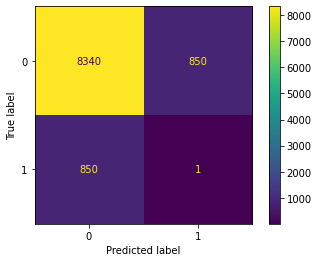

In [244]:
ConfusionMatrixDisplay(confusion_matrix(train_label, pred_train_auc)).plot()

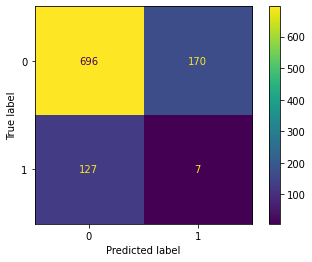

In [245]:
ConfusionMatrixDisplay(confusion_matrix(test_label, pred_test_auc)).plot()

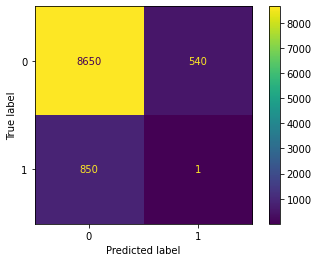

In [242]:
ConfusionMatrixDisplay(confusion_matrix(train_label, pred_train_f1)).plot()

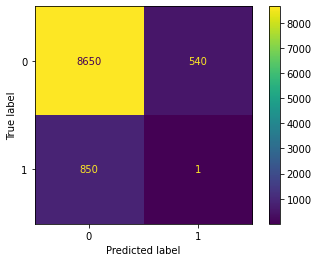

In [237]:
ConfusionMatrixDisplay(confusion_matrix(train_label, pred_cal)).plot()

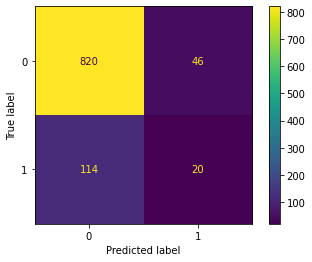

In [246]:
ConfusionMatrixDisplay(confusion_matrix(test_label, pred_test_f1)).plot()